# 05.2 - Classification Evaluation for Auto Tuned Prompts

In this notebook, we will evaluate the performance of the prompts tuned by the test models. For this evaluation, we will evlauate inter-model agrement, as well as look at the performance of prompts tuned by a each model against the other models.

In [ ]:
from aimu.prompts import PromptCatalog
from genscai import paths

catalog = PromptCatalog(paths.data / "prompt_catalog.db")
model_ids = catalog.retrieve_model_ids()
model_ids

In [2]:
import textwrap

for model_id in model_ids:
    print(f"model: {model_id}")

    prompt = catalog.retrieve_last(model_id)
    print(f"prompt revision: {prompt.version}")
    print(f"prompt metrics {prompt.metrics}")
    print(textwrap.fill(f"prompt: {prompt.prompt}", 100))
    print()

model: ollama:llama3.2:3b
prompt revision: 53
prompt metrics {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}
prompt: Read the following scientific paper abstract and note any language or content that
explicitly suggests or utilizes mathematical, statistical, or computational methods used to
simulate, analyze, predict, or interpret the dynamics of infectious outbreaks in specific geographic
regions with a focus on estimating the probability of resurgence, understanding the effectiveness of
novel intervention strategies, prioritizing care from a utilitarian perspective (minimizing
population health loss), and comparing different scenarios of delay or no intervention, specifically
through disease modeling techniques such as compartmental models, parameter estimation, sensitivity
analysis, simulation modeling, time-series analysis, Bayesian inference, Monte Carlo simulations,
and other advanced statistical techniques to inform evidence-based decision-making in the context of
analyzing e

## Delete poorly performing prompts from catalog

If there are prompts that poor performing and they should't be use for future analysis, they can be removed from the catalog.

In [ ]:
# catalog.delete_all("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")

## Classify the entire corpus using each of the local models.

The following script classifies all of the papers in the corpus using each of the local models. This takes a long time, since the full corpus is large. The script outputs four files (data/modeling_papers_N.json). Unless you'd like to re-run the classifications, ignore the following cell and continue with the analyses.

In [ ]:
# !python $paths.root/scripts/06_classification_all_models.py

## Evaluate inter-model agreement

Create an array of dataframes, each containing the papers classified as modeling papers by each of the models in MODEL_IDS.

In [ ]:
from aimu.models import HuggingFaceClient
from genscai import paths
import pandas as pd

MODEL_IDS = [
    HuggingFaceClient.MODEL_LLAMA_3_1_8B,
    HuggingFaceClient.MODEL_GEMMA_2_9B,
    HuggingFaceClient.MODEL_PHI_4_14B,
    HuggingFaceClient.MODEL_MISTRAL_NEMO_12B,
]

data = []
for i, model_id in enumerate(MODEL_IDS):
    df = pd.read_json(paths.data / f"modeling_papers_{i}.json", orient="records", lines=True)
    data.append(df)

Load the full MIDAS corpus into a dataframe. This dataframe will be used to determine inter-model agreement rates.

In [4]:
from genscai.data import load_midas_data

df1, df2, df3 = load_midas_data()
df_all = pd.concat([df1, df2, df3])

Detetmine inter-model agreement rates by comparing the classification of each model to the other models. The inter-model agreement rates are calculated as the number of papers classified the same (modeling or non-modeling) by both models divided by the total number of papers classified as modeling papers by either model. The inter-model agreement rates are stored in a dataframe.

In [5]:
rates = [[0] * len(data) for _ in [0] * len(data)]

print(f"total: {len(df_all)}")

for i in range(len(data)):
    for j in range(len(data)):
        df_intersection = pd.merge(data[i], data[j], how="inner", on=["id"])
        df_union = pd.merge(data[i], data[j], how="outer", on=["id"])

        rates[i][j] = (len(df_all) - len(df_union) + len(df_intersection)) / len(df_all)

        print(
            f"{MODEL_IDS[i]}, {MODEL_IDS[j]}: intersection={len(df_intersection)}, union={len(df_union)}, agreement_rate={rates[i][j]:.3f}"
        )

df = pd.DataFrame(data=rates, index=MODEL_IDS, columns=MODEL_IDS)

total: 11960
meta-llama/Meta-Llama-3.1-8B-Instruct, meta-llama/Meta-Llama-3.1-8B-Instruct: intersection=5737, union=5737, agreement_rate=1.000
meta-llama/Meta-Llama-3.1-8B-Instruct, google/gemma-2-9b-it: intersection=5310, union=6543, agreement_rate=0.897
meta-llama/Meta-Llama-3.1-8B-Instruct, microsoft/phi-4: intersection=3424, union=5843, agreement_rate=0.798
meta-llama/Meta-Llama-3.1-8B-Instruct, mistralai/Mistral-Nemo-Instruct-2407: intersection=4920, union=6756, agreement_rate=0.846
google/gemma-2-9b-it, meta-llama/Meta-Llama-3.1-8B-Instruct: intersection=5310, union=6543, agreement_rate=0.897
google/gemma-2-9b-it, google/gemma-2-9b-it: intersection=6116, union=6116, agreement_rate=1.000
google/gemma-2-9b-it, microsoft/phi-4: intersection=3492, union=6154, agreement_rate=0.777
google/gemma-2-9b-it, mistralai/Mistral-Nemo-Instruct-2407: intersection=5084, union=6971, agreement_rate=0.842
microsoft/phi-4, meta-llama/Meta-Llama-3.1-8B-Instruct: intersection=3424, union=5843, agreemen

Create a heatmap showing the inter-model agreement rates.

<Axes: >

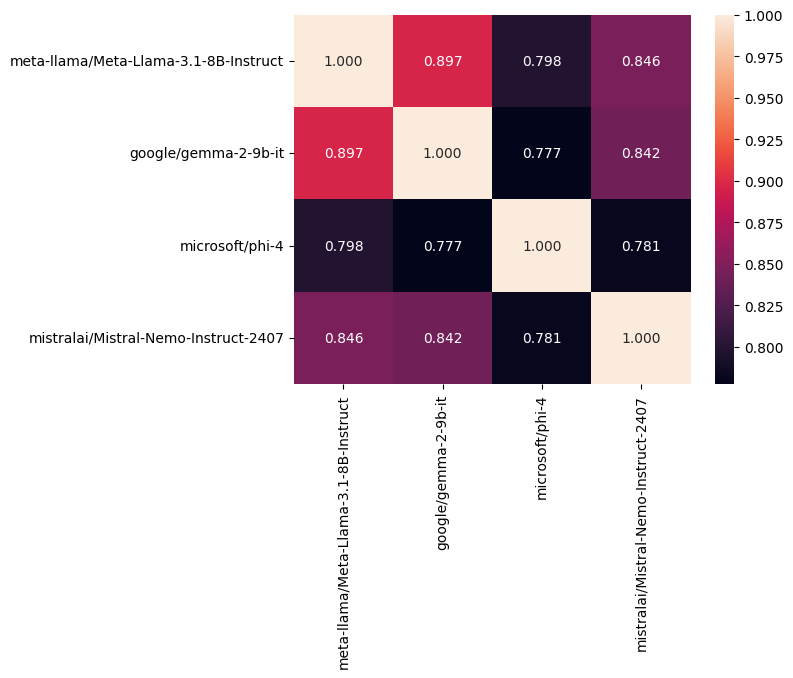

In [6]:
import seaborn as sns

sns.heatmap(df, annot=True, fmt=".3f")

## Evaluate inter-model prompt performance

This section explores the performance of the prompts tuned by each model. The performance of each prompt is determined by the perforance, accuracy, and recall of the prompt when used to classify the papers in the MIDAS training/test corpus.

The following script loads each of the prompts in the prompts in the prompt catalog and evaluates the performance of each prompt when used to classify the papers in the MIDAS training/test corpus. The output is written to the file "data/inter_model_results.txt".

In [ ]:
# !python $paths.root/scripts/04_classification_cross_model_validation.py

Load the prompt performance data from the file "data/inter_model_results.txt" into a dataframe.

In [7]:
import genscai.paths as paths
import pandas as pd
import json

dfs = {"precision": pd.DataFrame(), "recall": pd.DataFrame(), "accuracy": pd.DataFrame()}

with open(paths.data / "inter_model_results.txt", "r") as fin:
    for line in fin:
        if line.startswith("prompt"):
            line = line.strip()
            parts = line.split(", ")

            parts[0] = parts[0][len("prompt: ") :]
            parts[1] = parts[1][len("model: ") :]
            parts[2] = parts[2][len("metrics: ") :]

            metrics = ", ".join(parts[2:])
            metrics = metrics.replace("'", '"')
            data = json.loads(metrics)

            dfs["precision"].loc[parts[0], parts[1]] = data["precision"]
            dfs["recall"].loc[parts[0], parts[1]] = data["recall"]
            dfs["accuracy"].loc[parts[0], parts[1]] = data["accuracy"]

for df in dfs.values():
    df.rename_axis("Model", axis="columns", inplace=True)
    df.rename_axis("Prompt", axis="rows", inplace=True)
    df["mean"] = df.mean(axis=1)
    df.sort_values(by="mean", ascending=False, inplace=True)

dfs["accuracy"]

Model,meta-llama/Meta-Llama-3.1-8B-Instruct,microsoft/phi-4,google/gemma-2-9b-it,mistralai/Mistral-Nemo-Instruct-2407,deepseek-ai/DeepSeek-R1-Distill-Llama-8B,mean
Prompt,,,,,,
meta-llama/Meta-Llama-3.1-8B-Instruct,1.000000,0.984848,0.984848,0.939394,0.924242,0.966667
microsoft/phi-4,0.969697,1.000000,0.984848,0.939394,0.924242,0.963636
mistralai/Mistral-Nemo-Instruct-2407,0.954545,0.969697,0.939394,1.000000,0.954545,0.963636
openai:gpt-4o-mini,0.984848,0.984848,0.984848,0.984848,0.878788,0.963636
openai:gpt-4o,0.984848,1.000000,0.969697,0.969697,0.893939,0.963636
google/gemma-2-9b-it,0.939394,0.954545,1.000000,0.939394,0.939394,0.954545
ollama:llama3.1:8b,0.969697,0.984848,0.954545,0.924242,0.924242,0.951515
google/gemma-3-12b-it,NaN,NaN,NaN,NaN,0.924242,0.924242
ollama:llama3.2:3b,0.893939,0.833333,0.924242,0.757576,0.909091,0.863636


Plot the precision, recall, and accuracy of each prompt when used to classify the papers using each of the models.

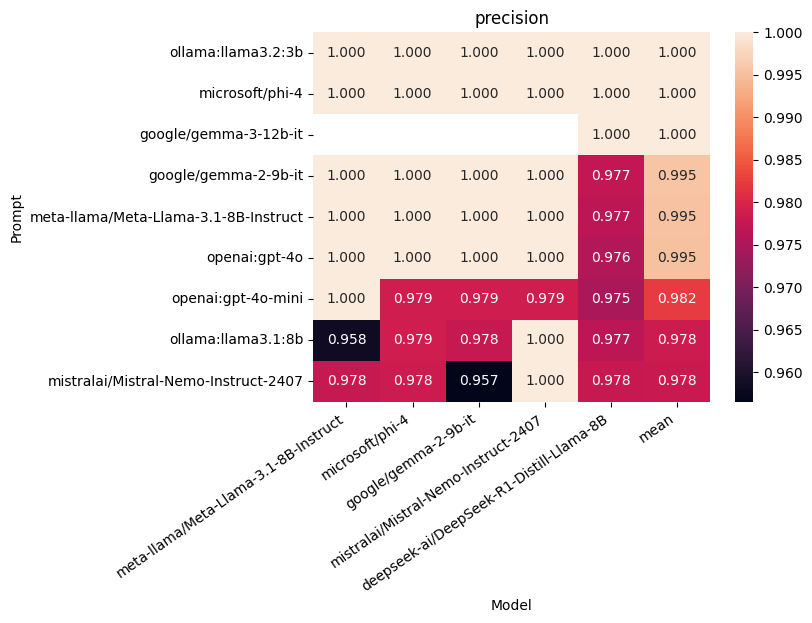

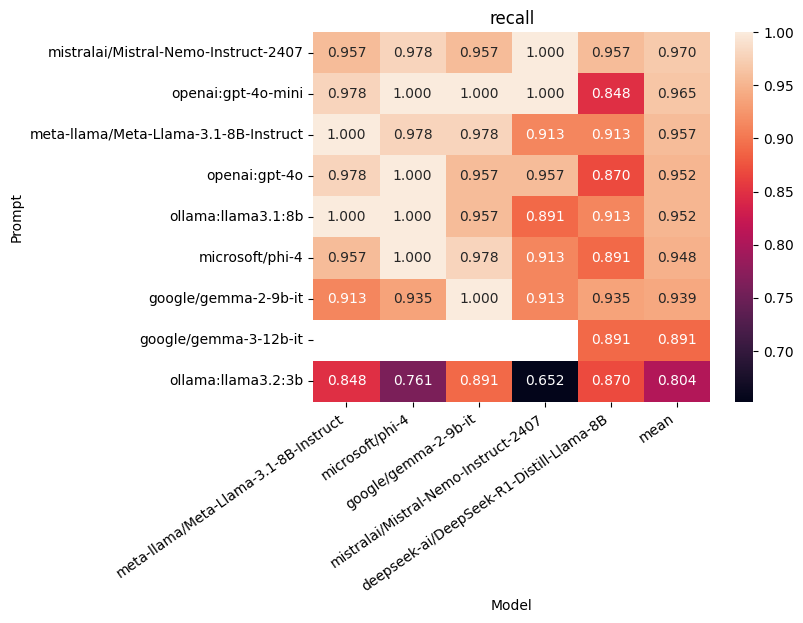

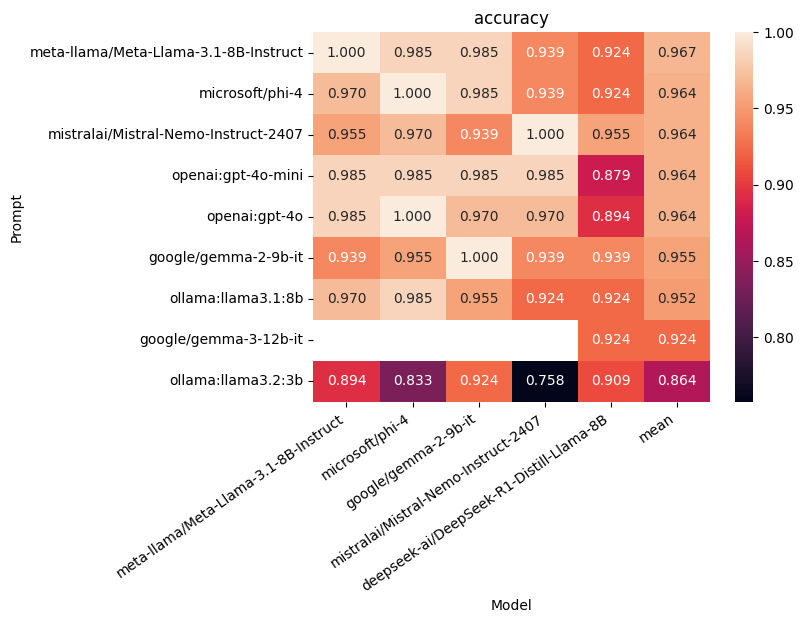

In [8]:
import matplotlib.pyplot as plt

for key, df in dfs.items():
    ax = plt.axes()
    ax.set_title(key)
    p = sns.heatmap(df, ax=ax, annot=True, fmt=".3f")
    ax.set_xticklabels(p.get_xticklabels(), rotation=35, horizontalalignment="right")
    plt.show()